##  GR DUSP1 Gating Notebook

The Purpose of this notebook is:
1) Load in all analyisis for final dataframe preparation 
2) Filter DUSP1 data to remove partial cells and low SNR spots
3) Filter GR data to remove partial cells
4) Estimate GR cytoplasmic area from DUPS1 data
5) GR intensity to molecular counts 
6) Concatonate final GR and DUSP1 dataframes

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.array as da
import os
import sys
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
numba_logger = logging.getLogger('numba')
numba_logger.setLevel(logging.WARNING)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(src_path)
sys.path.append(src_path)

from src.Analysis import AnalysisManager, Analysis, SpotDetection_SNRConfirmation, Spot_Cluster_Analysis_WeightedSNR, GR_Confirmation

/Users/ericron/Desktop/AngelFISH


In [ ]:
# Measure function to create final DUSP1 dataframe for SSIT
# Function to get the second largest value or default to 0
def second_largest(series):
    unique_vals = series.dropna().unique()  # Remove NaN and get unique values
    if len(unique_vals) < 2:
        return 0  # Return 0 if there's no second-largest value
    return np.sort(unique_vals)[-2]  # Return the second-largest value


def measure_DUSP1(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'Dex_conc', 'replica'])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)

    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    

    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # nuc area
    nuc_area = props['nuc_area']

    # cyto area
    cyto_area = props['cyto_area']

    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']

    # time (experiment)
    time = props['time'] 

    # Dex conc
    dex_conc = props['Dex_conc']

    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)

    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

def measure_DUSP1_TPL(spots, clusters, props) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'num_ts', 'num_spots_ts', 'largest_ts', 'second_largest_ts', 'num_foci', 'num_spots_foci', 'num_spots', 'num_nuc_spots', 'num_cyto_spots', 
                                    'nuc_area_px', 'cyto_area_px', 'avg_nuc_int', 'avg_cyto_int', 'time', 'time_tpl' 'Dex_conc', 'replica',
                                    'tryptCond1', 'tryptCond2', 'tryptCond3', 'tryptCond4', 'tryptCond5'])
    
    # Sort spots, clusters, and props by unique_cell_id
    spots = spots.sort_values(by='unique_cell_id')
    clusters = clusters.sort_values(by='unique_cell_id')
    props = props.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # num of ts
    num_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of foci
    num_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of ts spots
    num_spots_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # largest TS size
    largest_ts = clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].max().reindex(cell_ids, fill_value=0)

    # Compute second-largest TS size per cell
    second_largest_ts = (clusters[clusters['is_nuc'] == 1].groupby('unique_cell_id')['nb_spots'].apply(second_largest).reindex(cell_ids, fill_value=0))    

    # num of foci spots
    num_spots_foci = clusters[clusters['is_nuc'] == 0].groupby('unique_cell_id')['nb_spots'].sum().reindex(cell_ids, fill_value=0)

    # num of spots
    num_spots = spots.groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in nuc
    num_nuc_spots = spots[spots['is_nuc'] == 1].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # num of spot in cyto 
    num_cyto_spots = spots[spots['is_nuc'] == 0].groupby('unique_cell_id').size().reindex(cell_ids, fill_value=0)

    # nuc area
    nuc_area = props['nuc_area']

    # cyto area
    cyto_area = props['cyto_area']

    # avg int nuc
    avg_nuc_int = props['nuc_intensity_mean-0']
    
    # avg int cyto
    avg_cyto_int = props['cyto_intensity_mean-0']

    # time of Dex(experiment)
    time = props['time'] 

    # time of tpl
    time_tpl = props['time_tpl']

    # Dex conc
    dex_conc = props['Dex_conc']

    # Replica
    replica = spots.groupby('unique_cell_id')['replica'].first().reindex(cell_ids, fill_value=np.nan)

    # Extract unique TPL times
    trptTimes = np.sort(props['time_tpl'].dropna().unique())
    
    # Initialize tryptCond columns
    for k, t_TPL in enumerate(trptTimes, start=1):
        JJ = (
            ((dex_conc == 100) | (time == 0)) &
            ((time == 0) | ((time <= t_TPL) & time_tpl.isna()) | ((time >= t_TPL) & (time_tpl == t_TPL)))
        )
        results[f'tryptCond{k}'] = JJ.astype(int) * k
    
    # Populate DataFrame
    results['cell_id'] = cell_ids
    results['num_ts'] = num_ts.values
    results['largest_ts'] = largest_ts.values
    results['second_largest_ts'] = second_largest_ts.values
    results['num_foci'] = num_foci.values
    results['num_spots_ts'] = num_spots_ts.values
    results['num_spots_foci'] = num_spots_foci.values
    results['num_spots'] = num_spots.values
    results['num_nuc_spots'] = num_nuc_spots.values
    results['num_cyto_spots'] = num_cyto_spots.values
    results['nuc_area_px'] = nuc_area.values
    results['cyto_area_px'] = cyto_area.values
    results['avg_nuc_int'] = avg_nuc_int.values
    results['avg_cyto_int'] = avg_cyto_int.values
    results['time'] = time.values
    results['time_tpl'] = time_tpl.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results

# Measure function for GR pre-SSIT dataframe 
def measure_GR(cellprops) -> pd.DataFrame:
    results = pd.DataFrame(columns=['cell_id', 'nuc_area', 'nucGRint', 'cytoGRint', 'time', 'Dex_conc', 'replica'])
    
    # Sort cellprops by unique_cell_id
    props = cellprops.sort_values(by='unique_cell_id')

    # unique cell id
    cell_ids = props['unique_cell_id']

    # nuc area
    nuc_area = props['nuc_area']

    # avg int nuc
    nucGRint = props['nuc_intensity_mean-0']
    
    # avg int pseudocyto mask
    cytoGRint = props['cyto_intensity_mean-0']

    # time (experiment)
    time = props['time'] 

    # Dex conc
    dex_conc = props['Dex_conc']

    # Replica
    replica = props['replica']

    results['cell_id'] = cell_ids
    results['nuc_area'] = nuc_area.values
    results['nucGRint'] = nucGRint.values
    results['cytoGRint'] = cytoGRint.values
    results['time'] = time.values
    results['Dex_conc'] = dex_conc.values
    results['replica'] = replica.values

    return results    

# Use the log file to search for analyses

In [3]:
loc = None 
log_location = r'/Volumes/share/Users/Eric/GR_DUSP1_2025'  # r'/Volumes/share/Users/Jack/All_Analysis' 
am = AnalysisManager(location=loc, log_location=log_location, mac=True) 

In [4]:
# list all analysis done 
all_analysis_names = am.list_analysis_names()

Analysis_DUSP1_F_JacksRunAll_2025-02-06
Analysis_DUSP1_I_Jan2725_2025-01-27
Analysis_DUSP1_H_ERonRunAll_2025-02-06
Analysis_DUSP1_P_TPL_2025-02-05
Analysis_GR_IC_B_ReRun021025_2025-02-10
Analysis_DUSP1_E_ERonRunAll_2025-02-06
Analysis_DUSP1_O_TPL_2025-02-05
Analysis_DUSP1_O_JacksRunAll_2025-02-06
Analysis_DUSP1_M_ERonRunAll_2025-02-06
Analysis_DUSP1_G_JacksRunAll_2025-02-06
Analysis_DUSP1_I_JacksRunAll_2025-02-06
Analysis_DUSP1_FinalData_013125_2025-02-01
Analysis_DUSP1_K_JacksRunAll_2025-02-06
Analysis_DUSP1_K_ERonReRun_2025-02-08
Analysis_GR_IC_C_ER020725_2025-02-08
Analysis_DUSP1_F_ERonReRun_2025-02-08
Analysis_DUSP1_N_JacksRunAll_2025-02-06
Analysis_DUSP1_G_ERonReRun_2025-02-08
Analysis_DUSP1_L_JacksRunAll_2025-02-06
Analysis_GR_IC_A_ER020725_2025-02-07
Analysis_DUSP1_J_ERonRunAll_2025-02-06
Analysis_DUSP1_D_JacksRunAll_2025-02-05
Analysis_DUSP1_P_ERonReRun_2025-02-08
Analysis_DUSP1_FinalData_013125_2025-02-02


# DUSP1 Experiment Analysis List

### DUSP1 100nM Dex 3hr Time-sweep
- Replica D: `Analysis_DUSP1_D_JacksRunAll_2025-02-05`
- Replica E: `Analysis_DUSP1_E_ERonRunAll_2025-02-06`
- Replica F: `Analysis_DUSP1_F_ERonReRun_2025-02-08`
- Replica M: `Analysis_DUSP1_M_ERonRunAll_2025-02-06`
- Replica N: `Analysis_DUSP1_N_JacksRunAll_2025-02-06`

### DUSP1 75min Concentration-sweep
- Replica G: `Analysis_DUSP1_G_ERonReRun_2025-02-08`
- Replica H: `Analysis_DUSP1_H_ERonRunAll_2025-02-06`
- Replica I: `Analysis_DUSP1_I_JacksRunAll_2025-02-06`

### DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep
- Replica J: `Analysis_DUSP1_J_ERonRunAll_2025-02-06`
- Replica K: `Analysis_DUSP1_K_ERonReRun_2025-02-08`
- Replica L: `Analysis_DUSP1_L_JacksRunAll_2025-02-06`

### DUSP1 TPL
- Replica O `Analysis_DUSP1_O_JacksRunAll_2025-02-06`
- Replica P `Analysis_DUSP1_P_ERonReRun_2025-02-08`

# GR Experiment Analyis List

### GR 1, 10, 100nM Dex 3hr Time-Sweep
- Replica A: `Analysis_GR_IC_A_ER020725_2025-02-07`
- Replica B: `Analysis_GR_IC_B_ReRun021025_2025-02-10`
- Replica C: `Analysis_GR_IC_C_ER020725_2025-02-08`

## Example workflow

In [5]:
# Initiate the class and find analysis at log_location
# Select the specific analysis - ex. DUSP1 100nM Dex 3hr Time-sweep Replica 1
am.select_analysis('DUSP1_D_JacksRunAll')
print('locations with this dataset:', am.location)

locations with this dataset: ['/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_75min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_0min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_120min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_90min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_150min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220304/DUSP1_Dex_60min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_40min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220305/DUSP1_Dex_180min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220303/DUSP1_Dex_50min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_30min_20220224.h5', '/Volumes/share/smFISH_images/Eric_smFISH_images/20220225/DUSP1_Dex_20min_20220224.h5', 

In [6]:
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()

np.float64(2.823703393278696)

## Filter DUPS1 data to remove partial cells and low SNR spots

In [7]:
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))

# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]

# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]

# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')

In [8]:
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepD = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 100nM Dex 3hr Time-sweep Replica 2

In [9]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset - DUSP1 100nM Dex 3hr Time-sweep Replica 2
am.select_analysis('DUSP1_E_ERonRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepE = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 100nM Dex 3hr Time-sweep Replica 3

In [10]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_F_ERonReRun')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepF = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 100nM Dex 3hr Time-sweep Replica 4 (partial)

In [11]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_M_ERonRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepM = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 100nM Dex 3hr Time-sweep Replica 5 (partial)

In [12]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_N_JacksRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepN = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 75min Concentration-sweep Replica 1

In [13]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset - DUSP1 100nM Dex 3hr Time-sweep Replica 2
am.select_analysis('DUSP1_G_ERonReRun')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepG = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 75min Concentration-sweep Replica 2

In [14]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_H_ERonRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepH = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 75min Concentration-sweep Replica 3

In [15]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_I_JacksRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepI = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()                            

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 1

In [16]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_J_ERonRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepJ = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 2

In [17]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_K_ERonReRun')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepK = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 0.3, 1, 10nM Dex 3hr Time-sweep Replica 3

In [18]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_L_JacksRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepL = measure_DUSP1(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 1

In [19]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_O_JacksRunAll')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepO_TPL = measure_DUSP1_TPL(SD.spots, SD.clusters, SD.cellprops)
am.close()

    DUSP1 100nM Dex & 5µM TPL Time-sweep Replica 2

In [20]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('DUSP1_P_ERonReRun')
# Initiate the Weighted SNR analysis class
SD = Spot_Cluster_Analysis_WeightedSNR(am)
# Load the data
SD.get_data()
# Assign revise weighted threshold
SD.assign_revised_weighted_threshold()
# Create unique cell id for every cell
SD.cellprops['unique_cell_id'] = np.arange(len(SD.cellprops))
# Remove partial cells from dataset
SD.cellprops = SD.cellprops[SD.cellprops['touching_border'] == 0]
# Remove spots that are less than the weighted snr threshold
SD.spots = SD.spots[SD.spots['keep_wsnr']]
# Merge the spots and clusters dataframes by the unique cell ID
SD.spots = SD.spots.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
SD.clusters = SD.clusters.merge(SD.cellprops[['NAS_location', 'cell_label', 'fov', 'unique_cell_id']], 
                            on=['NAS_location', 'cell_label', 'fov'], 
                            how='left')
# Use measure_DUSP1 to create SSIT compatible dataframe
DUSP1_RepP_TPL = measure_DUSP1_TPL(SD.spots, SD.clusters, SD.cellprops)
am.close()

In [21]:
# Concatonate all DUSP1 Dex experiments & reset 'unique_cell_id'
DUSP1_ALL = pd.concat(
[DUSP1_RepD, DUSP1_RepE, DUSP1_RepF, DUSP1_RepM, DUSP1_RepN, DUSP1_RepG, DUSP1_RepH, DUSP1_RepI, DUSP1_RepJ, DUSP1_RepK, DUSP1_RepL], ignore_index=True) # 
DUSP1_ALL['unique_cell_id'] = np.arange(len(DUSP1_ALL))

### Filter GR data:
1. Remove partial cells
2. Use `measure_GR` to prepare pre-SSIT dataframe

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 1

In [22]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('GR_IC_A_ER020725')
# select GR conformation analysis 
GR = GR_Confirmation(am)
# Load the data
GR.get_data()
# Create unique cell id for every cell
GR.cellprops['unique_cell_id'] = np.arange(len(GR.cellprops))
# Remove partial cells from dataset
GR.cellprops = GR.cellprops[GR.cellprops['touching_border'] == 0]
# Use measure_GR to create SSIT compatible dataframe
GR_RepA = measure_GR(GR.cellprops)
am.close()

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 2

In [23]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('GR_IC_B_ReRun021025')
# select GR conformation analysis 
GR = GR_Confirmation(am)
# Load the data
GR.get_data()
# Create unique cell id for every cell
GR.cellprops['unique_cell_id'] = np.arange(len(GR.cellprops))
# Remove partial cells from dataset
GR.cellprops = GR.cellprops[GR.cellprops['touching_border'] == 0]
# Use measure_GR to create SSIT compatible dataframe
GR_RepB = measure_GR(GR.cellprops)
am.close()

    GR 1, 10, 100nM Dex 3hr Time-sweep Replica 3

In [24]:
# Initiate the class and find analysis at log_location
am = AnalysisManager(location=loc, log_location=log_location, mac=True)
# Select the dataset
am.select_analysis('GR_IC_C_ER020725')
# select GR conformation analysis 
GR = GR_Confirmation(am)
# Load the data
GR.get_data()
# Create unique cell id for every cell
GR.cellprops['unique_cell_id'] = np.arange(len(GR.cellprops))
# Remove partial cells from dataset
GR.cellprops = GR.cellprops[GR.cellprops['touching_border'] == 0]
# Use measure_GR to create SSIT compatible dataframe
GR_RepC = measure_GR(GR.cellprops)
am.close()

In [25]:
# Concatonate all DUSP1 Dex experiments & reset 'unique_cell_id'
GR_ALL = pd.concat(
[GR_RepA, GR_RepB, GR_RepC], ignore_index=True) # DUSP1_RepN, DUSP1_RepJ
GR_ALL['unique_cell_id'] = np.arange(len(GR_ALL))

In [26]:
GR_ALL

,cell_id,nuc_area,nucGRint,cytoGRint,time,Dex_conc,replica,unique_cell_id
0,0,5281.0,4107.575917,1458.351175,90,10,A,0
1,1,1185.0,4540.710137,1441.959556,90,10,A,1
2,2,8084.0,5442.916579,1504.375279,90,10,A,2
3,3,8027.0,6004.195356,1510.456026,90,10,A,3
4,4,9707.0,5299.208904,1546.691832,90,10,A,4
...,...,...,...,...,...,...,...,...
19221,5601,6167.0,3313.792397,1114.525882,120,10,C,19221
19222,5602,6750.0,2673.532505,1108.000027,120,10,C,19222
19223,5603,9728.0,3704.099971,1136.145253,120,10,C,19223
19224,5604,5593.0,3306.069900,1172.101178,120,10,C,19224


## GR_ALL & DUSP1_All final dataframe preperation for SSIT

1) Fit a Polynomial (2nd-degree) using (nuc_area_px, cyto_area_px) from DUSP1_ALL.

2) Estimate Cytoplasm Area in GR_ALL:
3) Creates `CalcCytoArea` by evaluating the fitted polynomial at each row’s `nuc_area`.

4) Gate both data sets on the 25%–75% range of nuclear area.

5) Compute “Normalized” GR (`normGRnuc`, `normGRcyt`) in GR_ALL:
- Scales nuclear/cyt intensities (5%→95% range) into integer bins [0,20].

6) Plot Histograms for the normalized nuclear/cyt GR (using custom colors).

7) Save the updated, gated data sets to CSV.

Fitted polynomial coefficients (a, b, c): [ 1.41472896e-04 -6.65876418e-02  5.35681132e+03]


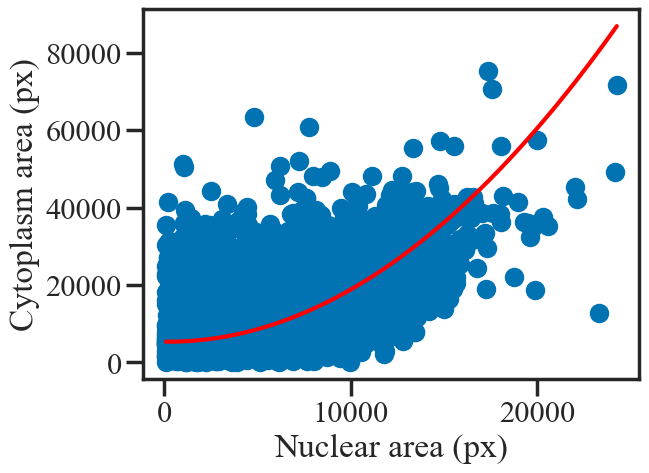

DUSP1_ALL original: 46114 rows -> gated: 23059 rows
GR_ALL original:    19226 rows -> gated: 9612 rows


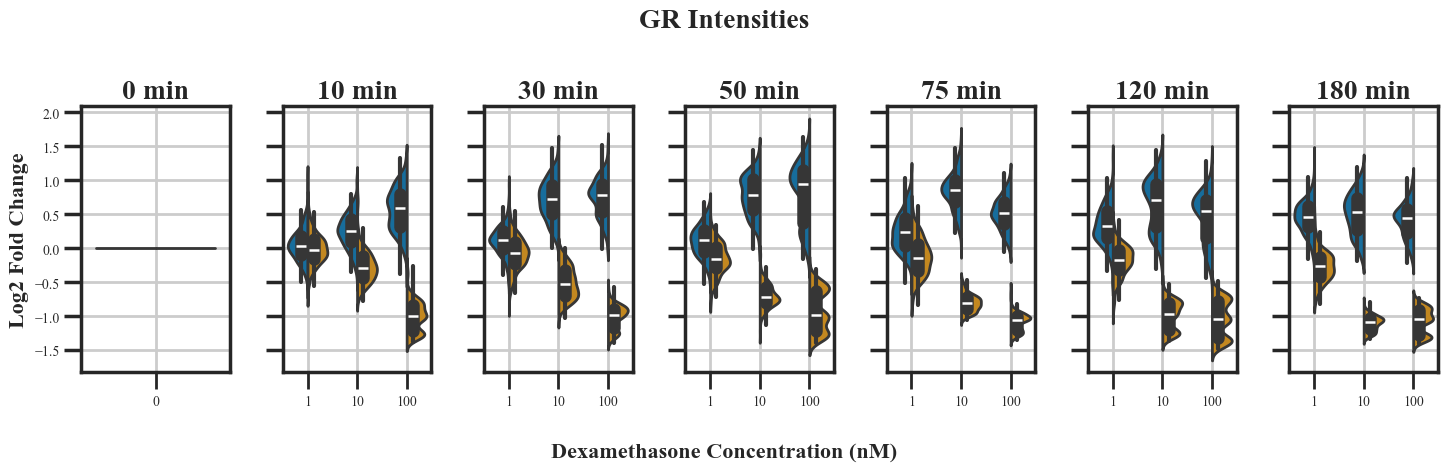

In [ ]:
# 1) READ INPUT DATA
# =========================
# DUSP1_ALL from above:
df_dusp = DUSP1_ALL

# GR_ALL from above:
df_gr = GR_ALL

# 2) FIT POLYNOMIAL TO (NUC, CYTO) FROM DUSP1_ALL
# =========================
# We'll use only the rows that have valid nuc_area_px and cyto_area_px.
df_dusp_nonmissing = df_dusp.dropna(subset=['nuc_area_px', 'cyto_area_px']).copy()

x_nuc = df_dusp_nonmissing['nuc_area_px'].values
y_cyto = df_dusp_nonmissing['cyto_area_px'].values

# Fit a 2nd-degree polynomial: cyto_area_px = a*(nuc_area_px)^2 + b*(nuc_area_px) + c
poly_coeffs = np.polyfit(x_nuc, y_cyto, deg=2)

# optional: for debugging/inspection
print("Fitted polynomial coefficients (a, b, c):", poly_coeffs)
# plot the fitted polynomial on the data
plt.scatter(x_nuc, y_cyto, label='data')
x_fit = np.linspace(x_nuc.min(), x_nuc.max(), 100)
y_fit = np.polyval(poly_coeffs, x_fit)
plt.plot(x_fit, y_fit, label='fitted polynomial', color='red')
plt.xlabel('Nuclear area (px)')
plt.ylabel('Cytoplasm area (px)')
plt.show()


# 3) ESTIMATE CYTO AREA IN GR_ALL
# =========================
# We'll store the computed cytoplasm area in a new column: 'CalcCytoArea'
# Evaluate the polynomial at GR_ALL['nuc_area'].
df_gr['CalcCytoArea'] = np.polyval(poly_coeffs, df_gr['nuc_area'])


# 4) GATE BOTH DATAFRAMES ON [25%, 75%] NUCLEAR AREA
# =========================
# We'll define a helper function for gating.
def gate_on_nuc_area(df, nuc_col):
    """Return a copy of df gated to [25th, 75th percentile] of nuc_col."""
    lower = df[nuc_col].quantile(0.25)
    upper = df[nuc_col].quantile(0.75)
    return df[(df[nuc_col] >= lower) & (df[nuc_col] <= upper)].copy()

# Gate DUSP1_ALL on nuc_area_px
df_dusp_gated = gate_on_nuc_area(df_dusp, 'nuc_area_px')

# Gate GR_ALL on nuc_area
df_gr_gated = gate_on_nuc_area(df_gr, 'nuc_area')

print(f"DUSP1_ALL original: {len(df_dusp)} rows -> gated: {len(df_dusp_gated)} rows")
print(f"GR_ALL original:    {len(df_gr)} rows -> gated: {len(df_gr_gated)} rows")


# 5) COMPUTE "NORMALIZED" GR FOR NUC & CYTO IN GR_ALL
# =========================
# We'll do a percentile-based normalization: 5th->95th percentile => mapped to [0, bins].
bins = 20

def normalize_by_percentiles(series, low_pct=0.05, high_pct=0.95, bins=20):
    """Scale 'series' into integer bins [0, bins] based on [low_pct, high_pct]."""
    lower_val = series.quantile(low_pct)
    upper_val = series.quantile(high_pct)
    clipped = (series - lower_val) / (upper_val - lower_val)
    clipped = clipped.clip(lower=0, upper=1)
    return (clipped * bins).round().astype(int)

df_gr_gated['normGRnuc'] = normalize_by_percentiles(df_gr_gated['nucGRint'], 0.05, 0.95, bins=bins)
df_gr_gated['normGRcyt'] = normalize_by_percentiles(df_gr_gated['cytoGRint'], 0.05, 0.95, bins=bins)


# 6) HISTOGRAMS
# =========================
# Add a column for ratio of nuclear to cytoplasmic GR
df_gr_gated['nuc_cyto_ratio'] = df_gr_gated['nucGRint'] / df_gr_gated['cytoGRint']

# Set the Seaborn style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Define the concentrations and specific timepoints you want to plot
concentrations = [0, 1, 10, 100]  # Including 0 concentration for baseline
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

# Prepare a DataFrame to store baseline values for each metric at time 0
baseline_data = df_gr_gated[df_gr_gated['Dex_conc'] == 0].groupby('time').mean(numeric_only=True)

# Metrics to plot
metrics = ['nucGRint', 'cytoGRint'] # , 'normGRnuc', 'normGRcyt', 'nuc_cyto_ratio'

# Calculate Log2 fold changes
for metric in metrics:
    baseline_column = f'baseline_{metric}'
    baseline_data[baseline_column] = baseline_data[metric]
    df_gr_gated[f'log2fc_{metric}'] = df_gr_gated.apply(
    lambda row: np.log2(row[metric] / baseline_data.at[0, metric]) if row['time'] != 0 else 0, axis=1)

# Melt the DataFrame to have 'metric' and 'log2fc_value' columns
melted_GR_data = df_gr_gated.melt(id_vars=['Dex_conc', 'time'], value_vars=[f'log2fc_{m}' for m in metrics],
                              var_name='metric', value_name='log2fc_value')

# Update the 'metric' column to have nicer labels
melted_GR_data['metric'] = melted_GR_data['metric'].str.replace('log2fc_', '').str.replace('_', ' ').str.title()

# Plotting
fig, axes = plt.subplots(1, len(desired_timepoints), figsize=(15, 5), sharey=True)
fig.suptitle('GR Intensities', fontsize=20, fontweight='bold', y=0.9)

for j, time in enumerate(desired_timepoints):
    ax = axes[j]
    data_subset = melted_GR_data[melted_GR_data['time'] == time]
    sns.violinplot(x='Dex_conc', y='log2fc_value', hue='metric', data=data_subset, linewidth=2.0, ax=ax, scale="width", split=True)
    ax.set_title(f"{time} min", fontsize=20, fontweight='bold')
    ax.set_xlabel(None)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=10, width=2)
    ax.tick_params(axis='y', labelsize=10)
    if j > 0:
        ax.set_ylabel('')  # Remove the y-label for all but the first subplot
    else:
        ax.set_ylabel('Log2 Fold Change', fontsize=16, fontweight='bold')
    ax.get_legend().remove()  # Remove the legend

# Set x-label for all subplots
fig.text(0.5, 0.004, 'Dexamethasone Concentration (nM)', ha='center', fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

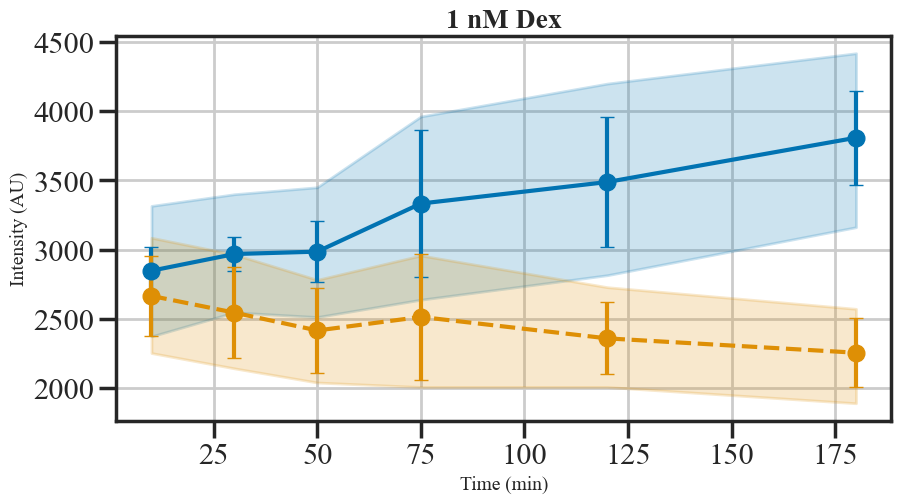

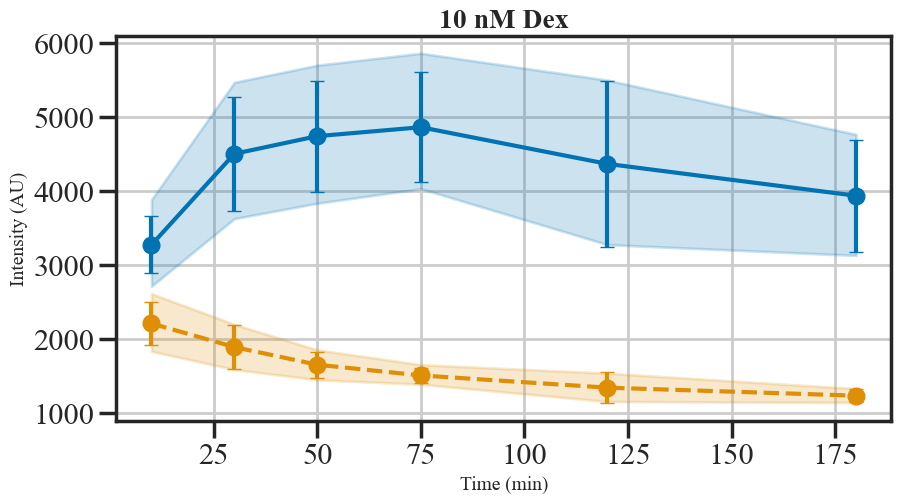

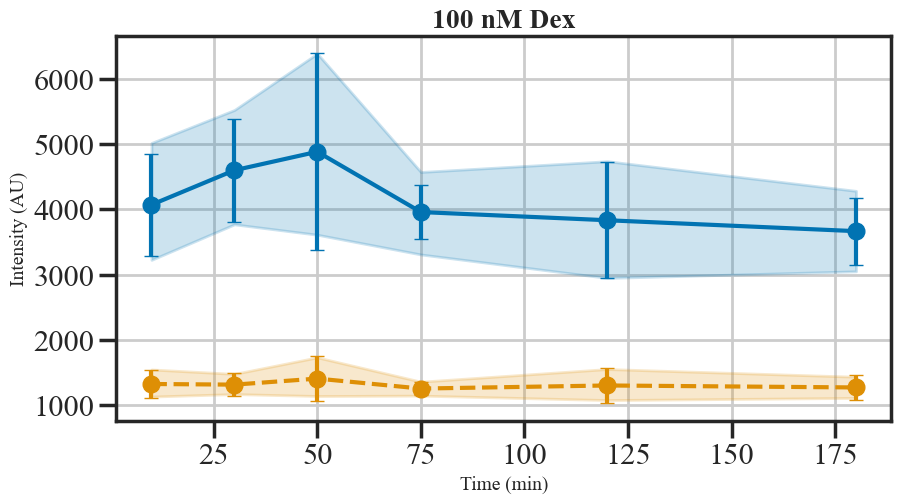

In [44]:
# Figure 1C: GR Intensity Over Time Separate concentration plots

# Make a copy of the GR data
GR_data = df_gr_gated.copy()

# Calculate means for each replica
replica_means = GR_data.groupby(['Dex_conc', 'time', 'replica']).agg({
    'nucGRint': 'mean',
    'cytoGRint': 'mean'
}).reset_index()

# Calculate the mean and standard deviation of the replica means
summary_stats = replica_means.groupby(['Dex_conc', 'time']).agg({
    'nucGRint': ['mean', 'std'],
    'cytoGRint': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
summary_stats.columns = ['Dex_conc', 'time', 'mean_nuc_int', 'std_nuc_int', 'mean_cyto_int', 'std_cyto_int']

# Calculate overall mean and standard deviation for each concentration and time point
overall_stats = GR_data.groupby(['Dex_conc', 'time']).agg({
    'nucGRint': ['mean', 'std'],
    'cytoGRint': ['mean', 'std']
}).reset_index()

# Rename columns for easier access
overall_stats.columns = ['Dex_conc', 'time', 'overall_mean_nuc', 'overall_std_nuc', 'overall_mean_cyto', 'overall_std_cyto']

# Set Style
sns.set_theme(style="ticks", palette="colorblind", context="poster", font='times new roman')

# Define the color palette for Nuclear and Cytoplasmic intensities
colors_nuc_cyto = sns.color_palette("colorblind", 2)  # Two colors: one for Nuclear, one for Cytoplasmic

# Define the desired time points
desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

for conc in [1, 10, 100]:
    # Filter data for plotting
    subset_summary = summary_stats[(summary_stats['Dex_conc'] == conc) & (summary_stats['time'].isin(desired_timepoints))]
    subset_overall = overall_stats[(overall_stats['Dex_conc'] == conc) & (overall_stats['time'].isin(desired_timepoints))]

    plt.figure(figsize=(10, 5))

    # Plotting Nuclear Intensity Mean with Error Bars
    plt.errorbar(subset_summary['time'], subset_summary['mean_nuc_int'],
                 yerr=subset_summary['std_nuc_int'], fmt='-o', color=colors_nuc_cyto[0], capsize=5,
                 label='Nuclear Intensity')

    # Filling between std deviations for overall data - Nuclear
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_nuc'] - subset_overall['overall_std_nuc'],
                     subset_overall['overall_mean_nuc'] + subset_overall['overall_std_nuc'],
                     color=colors_nuc_cyto[0], alpha=0.2, label='Total Data Spread - Nuclear')

    # Plotting Cytoplasmic Intensity Mean with Error Bars
    plt.errorbar(subset_summary['time'], subset_summary['mean_cyto_int'],
                 yerr=subset_summary['std_cyto_int'], fmt='--o', color=colors_nuc_cyto[1], capsize=5,
                 label='Cytoplasmic Intensity')

    # Filling between std deviations for overall data - Cytoplasmic
    plt.fill_between(subset_overall['time'],
                     subset_overall['overall_mean_cyto'] - subset_overall['overall_std_cyto'],
                     subset_overall['overall_mean_cyto'] + subset_overall['overall_std_cyto'],
                     color=colors_nuc_cyto[1], alpha=0.2, label='Total Data Spread - Cytoplasmic')

    # Customize the plot
    plt.title(f'{conc} nM Dex', fontsize=20, fontweight='bold')
    plt.xlabel('Time (min)', fontsize=14)
    plt.ylabel('Intensity (AU)', fontsize=14)
    plt.grid(True)
    #plt.legend()

    # Show the plot
    plt.show()

In [ ]:
# # 7) SAVE THE UPDATED GATED DATAFRAMES
# # =========================
# # Gated DUSP1 (unchanged except row filtering)
# df_dusp_gated.to_csv("DUSP1_ALL_gated_V01.csv", index=False)

# # Gated GR with new columns: CalcCytoArea, normGRnuc, normGRcyt
# df_gr_gated.to_csv("GR_ALL_gated_with_CytoArea_and_normGR_V01.csv", index=False)

# print("Saved gated DUSP1 to 'DUSP1_ALL_gated.csv'")
# print("Saved gated GR to 'GR_ALL_gated_with_CytoArea_and_normGR.csv'")

In [ ]:
# # Normalized Nuclear GR, Normalized Cytopasmic GR & Ratio Histograms  
# GR_data = GR_data.copy()
# # Add acolumn for ratio of nuclear to cytoplasmic GR
# GR_data['nuc_cyto_ratio'] = GR_data['nuc_GR_intensity'] / GR_data['cyto_GR_intensity']

# # Set the colorblind theme for accessibility
# sns.set(style="ticks", palette="colorblind", context="poster", font='times new roman')

# # Define the concentrations and specific timepoints you want to plot
# concentrations = [1, 10, 100]  # nM concentrations
# desired_timepoints = [0, 10, 30, 50, 75, 120, 180]

# # Metrics to plot and their corresponding labels
# metrics = ['nuc_GR_intensity', 'cyto_GR_intensity', 'nuc_cyto_ratio']
# labels = {
#     'nuc_GR_intensity': 'Nuclear GR Intensity',
#     'cyto_GR_intensity': 'Cytoplasmic GR Intensity',
#     'nuc_cyto_ratio': 'Nuc/Cyto Ratio'
# }

# # Define axis limits for each metric
# axis_limits = {
#     'nuc_GR_intensity': (1000, 6000),
#     'cyto_GR_intensity': (100, 4000),
#     'nuc_cyto_ratio': (0, 5)
# }

# # Generate colors from the Seaborn colorblind palette
# colors = sns.color_palette("colorblind", len(concentrations) + 1)  # Including color for 0 concentration
# concentration_color_map = dict(zip([0] + concentrations, colors))

# # Plotting
# for metric in metrics:
#     fig, axes = plt.subplots(len(concentrations), len(desired_timepoints), figsize=(20, 10), sharey='row')
#     for i, conc in enumerate(concentrations):
#         for j, time in enumerate(desired_timepoints):
#             ax = axes[i, j]
#             # Filter data for specific concentration and timepoint
#             if time == 0:
#                 data_subset = GR_data[(GR_data['time'] == 0)]
#                 color = concentration_color_map[0]
#                 title = "Common 0min"
#             else:
#                 data_subset = GR_data[(GR_data['Dex_conc'] == conc) & (GR_data['time'] == time)]
#                 color = concentration_color_map[conc]
#                 title = f"{time}min"

#             sns.histplot(data=data_subset, x=metric, kde=True, color=color, linewidth=1, bins=20, ax=ax, element='bars', fill=True, line_kws={'linewidth': 5}, legend=False, alpha=0.9)
#             ax.set_xlim(axis_limits[metric])
#             ax.set_title(title)
#             ax.set_xlabel(labels[metric] if i == len(concentrations) - 1 else '')  # Only show x-axis label on the bottom plots
#             ax.set_ylabel('Density' if j == 0 else '')  # Only show y-axis label on the first column

#     plt.suptitle(f"{labels[metric]} by Dexamethasone Concentration and Time", fontsize=24, fontweight='bold')
#     fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
#     plt.show()